In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor

# Download Dataset

In [170]:
data = pd.read_csv('https://richardson.byu.edu/220/OnlineNewsPopularity.csv', delimiter=',\s+', engine='python')
data

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


# Exploratory Data Analysis

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


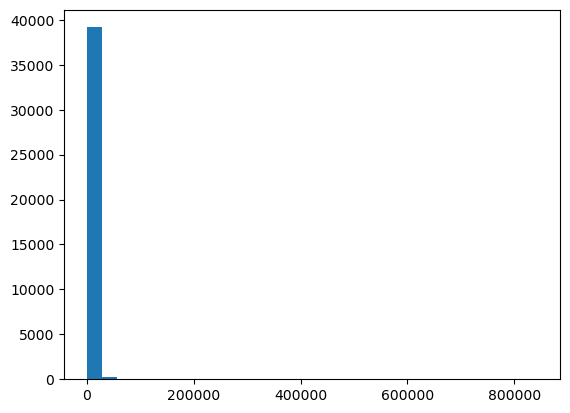

In [171]:
# 1. Plot the target variable. Determine if the target variable seems appropriate or if any transformations are needed.
shares = data.iloc[:, -1]

print(shares.describe())

plt.hist(shares, bins=30)

plt.show()

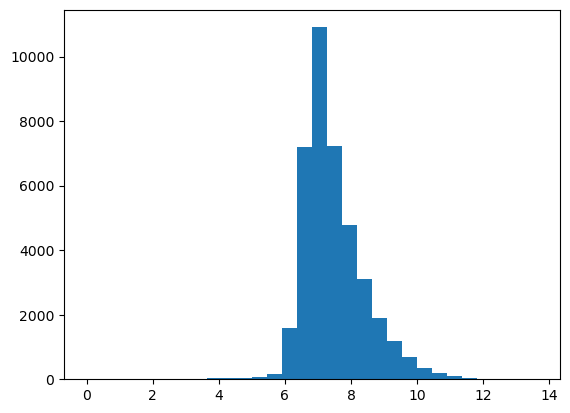

In [172]:
# Apply a log transform because the variables shares are heavily skewed
shares = np.log(shares)

plt.hist(shares, bins=30)

plt.show()

In [173]:
# 2. Build a linear regression model without higher-order terms and identify the most significant predictors.
def remove_worst_feature(model, X):
    worst_feature = model.pvalues.drop("const").idxmax()
    print(f"Removing {worst_feature} with p-value {model.pvalues.max()}")
    X = X.drop(worst_feature, axis=1)
    return X

def remove_insignificant_features(model, X, y, p=0.05):
    while model.pvalues.max() > p:
        X = remove_worst_feature(model, X)
        model = sm.OLS(y, X).fit()
    return model, X

X = data.drop(["shares", "url"], axis=1).astype(float)
X = sm.add_constant(X)
y = np.log(data["shares"]).astype(float)

linear_model = sm.OLS(y, X).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     101.0
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:32:20   Log-Likelihood:                -50705.
No. Observations:               39644   AIC:                         1.015e+05
Df Residuals:                   39586   BIC:                         1.020e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -23.8866    394.230     -0.061      0.952    -796.587     748.814
timedelta                      6.156e-05   2.97e-05      2.073      0.038    3.36e-06       0.000
n_tokens_title                    0.0081      0.002      3.689      0.000       0.004       0.012
n_tokens_content                4.06e-05   1.69e-05      2.401      0.016    7.45e-06    7.37e-05
n_unique_tokens                   0.1626      0.146      1.117      0.264      -0.123       0.448
n_non_stop_words                  0.0769      0.447      0.172      0.863      -0.800       0.953
n_non_stop_unique_tokens         -0.2426      0.123     -1.966      0.049      -0.484      -0.001
num_hrefs                         0.0042      0.001      8.290      0.000       0.003       0.005
num_self_hrefs                   -0.0080      0.001     -5.916      0.000      -0.011      -0.005
num_imgs                          0.0024      0.001      3.583      0.000       0.001       0.004
num_videos                        0.0019      0.001      1.601      0.109      -0.000       0.004
average_token_length             -0.0919      0.018     -4.997      0.000      -0.128      -0.056
num_keywords                      0.0119      0.003      4.250      0.000       0.006       0.017
data_channel_is_lifestyle        -0.1025      0.030     -3.427      0.001      -0.161      -0.044
data_channel_is_entertainment    -0.1797      0.019     -9.265      0.000      -0.218      -0.142
data_channel_is_bus              -0.1657      0.029     -5.721      0.000      -0.222      -0.109
data_channel_is_socmed            0.1607      0.028      5.698      0.000       0.105       0.216
data_channel_is_tech              0.1028      0.028      3.653      0.000       0.048       0.158
data_channel_is_world            -0.0385      0.029     -1.345      0.179      -0.095       0.018
kw_min_min                        0.0009      0.000      7.227      0.000       0.001       0.001
kw_max_min                     1.706e-05   3.81e-06      4.477      0.000    9.59e-06    2.45e-05
kw_avg_min                       -0.0001   2.34e-05     -5.438      0.000      -0.000   -8.15e-05
kw_min_max                    -3.535e-07   8.91e-08     -3.968      0.000   -5.28e-07   -1.79e-07
kw_max_max                     5.049e-08   4.46e-08      1.131      0.258    -3.7e-08    1.38e-07
kw_avg_max                    -2.872e-07   6.42e-08     -4.475      0.000   -4.13e-07   -1.61e-07
kw_min_avg                    -5.044e-05   5.72e-06     -8.812      0.000   -6.17e-05   -3.92e-05
kw_max_avg                    -4.188e-05   1.91e-06    -21.872      0.000   -4.56e-05   -3.81e-05
kw_avg_avg                        0.0003   1.09e-05     30.768      0.000       0.000       0.000
self_reference_min_shares      7.394e-07   5.

In [174]:
tuned_model, tuned_X = remove_insignificant_features(linear_model, X, y)
tuned_model.summary()

Removing self_reference_max_shares with p-value 0.9985225129173783
Removing avg_positive_polarity with p-value 0.9711130490554427
Removing weekday_is_saturday with p-value 0.9546266486279503
Removing is_weekend with p-value 0.954583839408575
Removing LDA_02 with p-value 0.9523481420933932
Removing min_negative_polarity with p-value 0.88939371480128
Removing weekday_is_sunday with p-value 0.8860736278559794
Removing global_rate_negative_words with p-value 0.6270525305499155
Removing max_positive_polarity with p-value 0.3997371499616633
Removing n_non_stop_words with p-value 0.44618402168361715
Removing abs_title_sentiment_polarity with p-value 0.37811851191539325
Removing kw_max_max with p-value 0.2592122979978594
Removing data_channel_is_world with p-value 0.22100542541512572
Removing max_negative_polarity with p-value 0.21880833497859853
Removing num_videos with p-value 0.10673030213012387
Removing global_sentiment_polarity with p-value 0.07046144419701945
Removing self_reference_min_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     136.7
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:32:22   Log-Likelihood:                -50713.
No. Observations:               39644   AIC:                         1.015e+05
Df Residuals:                   39601   BIC:                         1.019e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.5863      0.054    122.400      0.000       6.481       6.692
timedelta                      5.821e-05   2.87e-05      2.031      0.042    2.04e-06       0.000
n_tokens_title                    0.0081      0.002      3.657      0.000       0.004       0.012
n_tokens_content               5.194e-05   1.26e-05      4.132      0.000    2.73e-05    7.66e-05
n_unique_tokens                   0.2624      0.109      2.399      0.016       0.048       0.477
n_non_stop_unique_tokens         -0.2799      0.118     -2.374      0.018      -0.511      -0.049
num_hrefs                         0.0042      0.001      8.441      0.000       0.003       0.005
num_self_hrefs                   -0.0080      0.001     -6.104      0.000      -0.011      -0.005
num_imgs                          0.0023      0.001      3.474      0.001       0.001       0.004
average_token_length             -0.0955      0.018     -5.341      0.000      -0.131      -0.060
num_keywords                      0.0124      0.003      4.458      0.000       0.007       0.018
data_channel_is_lifestyle        -0.0830      0.025     -3.270      0.001      -0.133      -0.033
data_channel_is_entertainment    -0.1647      0.017     -9.646      0.000      -0.198      -0.131
data_channel_is_bus              -0.1463      0.024     -6.080      0.000      -0.193      -0.099
data_channel_is_socmed            0.1828      0.023      7.887      0.000       0.137       0.228
data_channel_is_tech              0.1262      0.022      5.863      0.000       0.084       0.168
kw_min_min                        0.0008   8.64e-05      9.334      0.000       0.001       0.001
kw_max_min                     1.742e-05   3.81e-06      4.578      0.000    9.96e-06    2.49e-05
kw_avg_min                       -0.0001   2.34e-05     -5.498      0.000      -0.000   -8.28e-05
kw_min_max                    -3.716e-07   8.83e-08     -4.210      0.000   -5.45e-07   -1.99e-07
kw_avg_max                    -2.527e-07   6.05e-08     -4.177      0.000   -3.71e-07   -1.34e-07
kw_min_avg                    -5.138e-05    5.7e-06     -9.017      0.000   -6.25e-05   -4.02e-05
kw_max_avg                    -4.254e-05   1.89e-06    -22.512      0.000   -4.62e-05   -3.88e-05
kw_avg_avg                        0.0003   1.07e-05     31.601      0.000       0.000       0.000
self_reference_avg_sharess     1.946e-06   1.85e-07     10.525      0.000    1.58e-06    2.31e-06
weekday_is_monday                -0.2205      0.016    -13.573      0.000      -0.252      -0.189
weekday_is_tuesday               -0.2875      0.016    -18.108      0.000      -0.319      -0.256
weekday_is_wednesday             -0.2843      0.016    -17.902      0.000      -0.315      -0.253
weekday_is_thursday              -0.2789     

In [175]:
sorted_features = sorted(zip(tuned_model.pvalues.index, tuned_model.pvalues), key=lambda x: x[1])
sorted_features = pd.DataFrame(sorted_features, columns=["Feature", "P-value"])
print(f"The five most significant features are:\n{sorted_features.drop(0).head()}")
sorted_features

The five most significant features are:
                Feature        P-value
1            kw_avg_avg  1.788142e-216
2            kw_max_avg  1.595246e-111
3    weekday_is_tuesday   5.428202e-73
4  weekday_is_wednesday   2.182979e-71
5   weekday_is_thursday   2.468833e-68


,Feature,P-value
0,const,0.000000e+00
1,kw_avg_avg,1.788142e-216
2,kw_max_avg,1.595246e-111
3,weekday_is_tuesday,5.428202e-73
4,weekday_is_wednesday,2.182979e-71
5,weekday_is_thursday,2.468833e-68
6,weekday_is_monday,7.216608e-42
7,LDA_00,5.191217e-40
8,weekday_is_friday,1.598841e-37
9,self_reference_avg_sharess,7.185713e-26


In [176]:
# 3. Build a regression tree to identify important predictors.
# params = {
#    "max_depth": np.arange(3, 8),
#    "min_samples_split": np.arange(1, 4),
#    "min_samples_leaf": np.arange(1, 4)
#}

tree = DecisionTreeRegressor(max_depth=4, min_samples_split=3, min_samples_leaf=1)
tree.fit(X, y)

importances = sorted(zip(X.columns, tree.feature_importances_), key=lambda x: x[1], reverse=True)
importances = pd.DataFrame(importances, columns=["Feature", "Importance"])
print(f"The non-zero importance features are:\n{importances.head(8)}")

# grid = GridSearchCV(tree, params, cv=5, scoring="r2", verbose=3)
# grid.fit(X, y)

# print(f"Best Parameters: {grid.best_params_}")

The non-zero importance features are:
                         Feature  Importance
0                     kw_avg_avg    0.549448
1     self_reference_avg_sharess    0.204873
2                     kw_max_avg    0.077330
3                      timedelta    0.057225
4  data_channel_is_entertainment    0.049582
5                     is_weekend    0.032430
6           data_channel_is_tech    0.021046
7                       num_imgs    0.008066


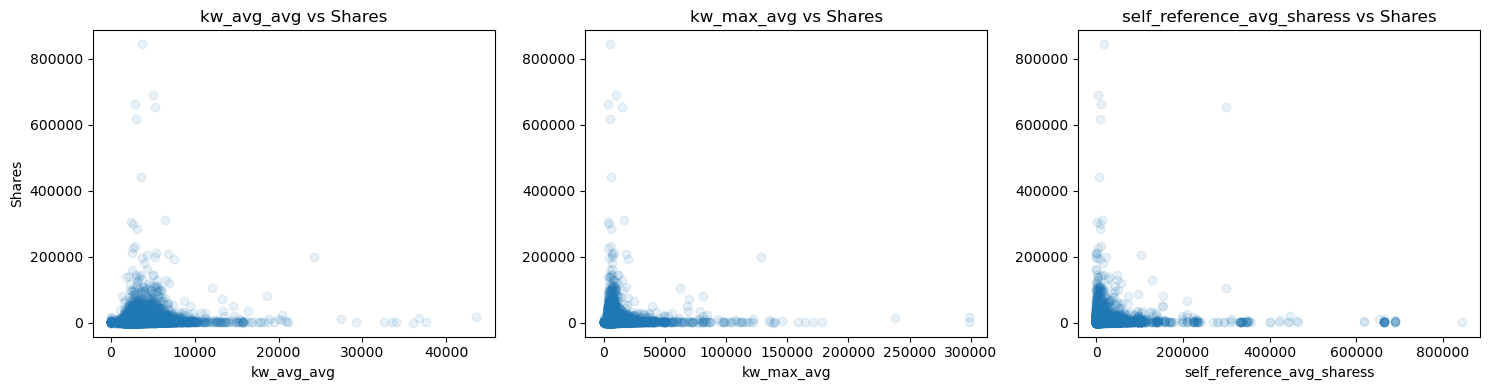

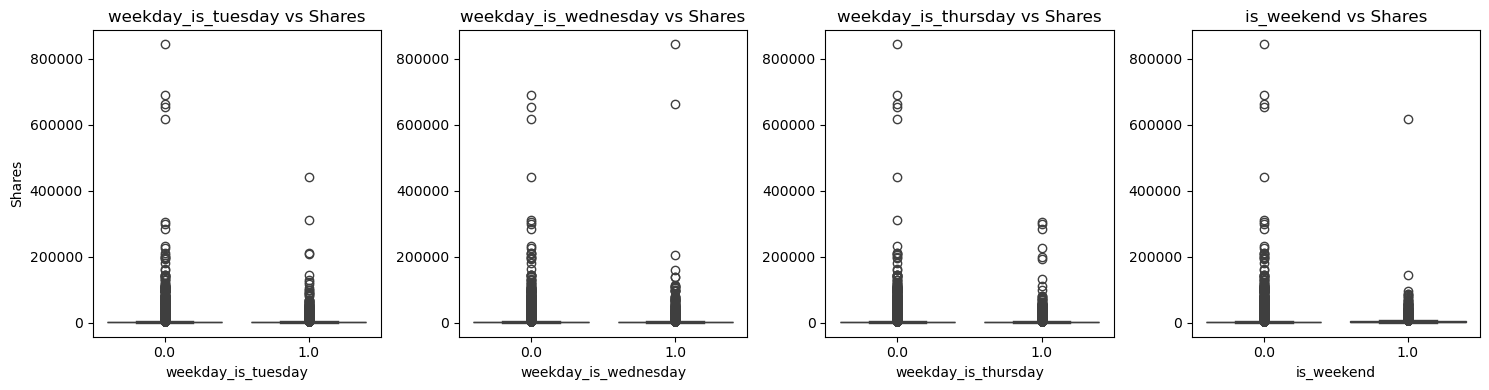

In [177]:
# 4. Select several significant features from steps 2 and 3. Create visualizations or
# tables to explore the relationships between these features and the target variable.
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_relationships(data, continuous_features, binary_features, target='shares'):
    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(continuous_features, 1):
        plt.subplot(1, len(continuous_features), i)
        plt.scatter(data[feature], data[target], alpha=0.1)
        plt.xlabel(feature)
        plt.ylabel('Shares' if i == 1 else '')
        plt.title(f'{feature} vs Shares')
    plt.tight_layout()
    plt.show()
    
    # Plot binary features
    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(binary_features, 1):
        plt.subplot(1, len(binary_features), i)
        sns.boxplot(x=feature, y=target, data=data)
        plt.ylabel('Shares' if i == 1 else '')
        plt.title(f'{feature} vs Shares')
    plt.tight_layout()
    plt.show()

continuous = ["kw_avg_avg", "kw_max_avg", "self_reference_avg_sharess", 
              "timedelta", "num_imgs"]
binary = ["weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday",
          "is_weekend", "data_channel_is_entertainment", "data_channel_is_tech"]

continuous = continuous[:-2]
binary = binary[:-2]

sig_features = continuous + binary

plot_feature_relationships(data, continuous, binary)

5. Write an EDA section in your technical report. Report the results of the initial models and include figures or tables that show the target variable and its
relationship with potentially significant predictors.

In [178]:
# 6. Use appropriate methods to remove insignificant variables from the model.
X = data.drop(["shares", "url"], axis=1).astype(float)
X = sm.add_constant(X)
y = np.log(data["shares"]).astype(float)

linear_model = sm.OLS(y, X).fit()

tuned_model, tuned_X = remove_insignificant_features(linear_model, X, y)
tuned_model.summary()

Removing self_reference_max_shares with p-value 0.9985225129173783
Removing avg_positive_polarity with p-value 0.9711130490554427
Removing weekday_is_saturday with p-value 0.9546266486279503
Removing is_weekend with p-value 0.954583839408575
Removing LDA_02 with p-value 0.9523481420933932
Removing min_negative_polarity with p-value 0.88939371480128
Removing weekday_is_sunday with p-value 0.8860736278559794
Removing global_rate_negative_words with p-value 0.6270525305499155
Removing max_positive_polarity with p-value 0.3997371499616633
Removing n_non_stop_words with p-value 0.44618402168361715
Removing abs_title_sentiment_polarity with p-value 0.37811851191539325
Removing kw_max_max with p-value 0.2592122979978594
Removing data_channel_is_world with p-value 0.22100542541512572
Removing max_negative_polarity with p-value 0.21880833497859853
Removing num_videos with p-value 0.10673030213012387
Removing global_sentiment_polarity with p-value 0.07046144419701945
Removing self_reference_min_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     136.7
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:32:24   Log-Likelihood:                -50713.
No. Observations:               39644   AIC:                         1.015e+05
Df Residuals:                   39601   BIC:                         1.019e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.5863      0.054    122.400      0.000       6.481       6.692
timedelta                      5.821e-05   2.87e-05      2.031      0.042    2.04e-06       0.000
n_tokens_title                    0.0081      0.002      3.657      0.000       0.004       0.012
n_tokens_content               5.194e-05   1.26e-05      4.132      0.000    2.73e-05    7.66e-05
n_unique_tokens                   0.2624      0.109      2.399      0.016       0.048       0.477
n_non_stop_unique_tokens         -0.2799      0.118     -2.374      0.018      -0.511      -0.049
num_hrefs                         0.0042      0.001      8.441      0.000       0.003       0.005
num_self_hrefs                   -0.0080      0.001     -6.104      0.000      -0.011      -0.005
num_imgs                          0.0023      0.001      3.474      0.001       0.001       0.004
average_token_length             -0.0955      0.018     -5.341      0.000      -0.131      -0.060
num_keywords                      0.0124      0.003      4.458      0.000       0.007       0.018
data_channel_is_lifestyle        -0.0830      0.025     -3.270      0.001      -0.133      -0.033
data_channel_is_entertainment    -0.1647      0.017     -9.646      0.000      -0.198      -0.131
data_channel_is_bus              -0.1463      0.024     -6.080      0.000      -0.193      -0.099
data_channel_is_socmed            0.1828      0.023      7.887      0.000       0.137       0.228
data_channel_is_tech              0.1262      0.022      5.863      0.000       0.084       0.168
kw_min_min                        0.0008   8.64e-05      9.334      0.000       0.001       0.001
kw_max_min                     1.742e-05   3.81e-06      4.578      0.000    9.96e-06    2.49e-05
kw_avg_min                       -0.0001   2.34e-05     -5.498      0.000      -0.000   -8.28e-05
kw_min_max                    -3.716e-07   8.83e-08     -4.210      0.000   -5.45e-07   -1.99e-07
kw_avg_max                    -2.527e-07   6.05e-08     -4.177      0.000   -3.71e-07   -1.34e-07
kw_min_avg                    -5.138e-05    5.7e-06     -9.017      0.000   -6.25e-05   -4.02e-05
kw_max_avg                    -4.254e-05   1.89e-06    -22.512      0.000   -4.62e-05   -3.88e-05
kw_avg_avg                        0.0003   1.07e-05     31.601      0.000       0.000       0.000
self_reference_avg_sharess     1.946e-06   1.85e-07     10.525      0.000    1.58e-06    2.31e-06
weekday_is_monday                -0.2205      0.016    -13.573      0.000      -0.252      -0.189
weekday_is_tuesday               -0.2875      0.016    -18.108      0.000      -0.319      -0.256
weekday_is_wednesday             -0.2843      0.016    -17.902      0.000      -0.315      -0.253
weekday_is_thursday              -0.2789     

# Linear Regression Modeling 

In [179]:
# 1. Split the data into training and testing sets. Use the training set for model fitting
# and the testing set to check for overfitting and predictive performance.
X_train, X_test, y_train, y_test = train_test_split(X[sig_features], y, test_size=0.2, random_state=0)
X_train

,kw_avg_avg,kw_max_avg,self_reference_avg_sharess,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,is_weekend
8002,3387.545041,5255.942857,1300.0,0.0,0.0,1.0,0.0
3977,2412.119932,3933.904762,3700.0,0.0,0.0,0.0,0.0
32942,4697.088251,6010.020591,4300.0,0.0,1.0,0.0,0.0
33249,2740.541021,3781.925926,2060.0,1.0,0.0,0.0,0.0
29990,3093.589689,4972.250000,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
20757,3130.463537,5397.650000,2050.0,0.0,0.0,1.0,0.0
32103,4881.433290,7581.226923,8300.0,0.0,0.0,1.0,0.0
30403,5638.004127,7191.255556,0.0,0.0,0.0,1.0,0.0
21243,2683.482028,3996.276753,7900.0,0.0,0.0,0.0,1.0


In [180]:
# 2. Explore transformations of the target and other variables.
print(X_train.columns)

X_train_cont = X_train.drop(binary, axis=1)
X_test_cont = X_test.drop(binary, axis=1)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont), columns=X_train_cont.columns, index=X_train_cont.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_cont), columns=X_test_cont.columns, index=X_test_cont.index)

for feature in binary:
    print(f"Adding back {feature}")
    X_train_scaled[feature] = X_train[feature]
    X_test_scaled[feature] = X_test[feature]

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train_scaled), columns=poly.get_feature_names_out(X_train_scaled.columns), index=X_train_scaled.index)
X_test_poly = pd.DataFrame(poly.transform(X_test_scaled), columns=poly.get_feature_names_out(X_test_scaled.columns), index=X_test_scaled.index)

X_train_poly = X_train_poly.rename(columns={"1": "const"})
X_test_poly = X_test_poly.rename(columns={"1": "const"})

X_train_poly

Index(['kw_avg_avg', 'kw_max_avg', 'self_reference_avg_sharess',
       'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
       'is_weekend'],
      dtype='object')
Adding back weekday_is_tuesday
Adding back weekday_is_wednesday
Adding back weekday_is_thursday
Adding back is_weekend


,const,kw_avg_avg,kw_max_avg,self_reference_avg_sharess,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,is_weekend,kw_avg_avg kw_max_avg,kw_avg_avg self_reference_avg_sharess,...,self_reference_avg_sharess weekday_is_tuesday,self_reference_avg_sharess weekday_is_wednesday,self_reference_avg_sharess weekday_is_thursday,self_reference_avg_sharess is_weekend,weekday_is_tuesday weekday_is_wednesday,weekday_is_tuesday weekday_is_thursday,weekday_is_tuesday is_weekend,weekday_is_wednesday weekday_is_thursday,weekday_is_wednesday is_weekend,weekday_is_thursday is_weekend
8002,1.0,0.198829,-0.064191,-0.210893,0.0,0.0,1.0,0.0,-0.012763,-0.041932,...,-0.000000,-0.000000,-0.210893,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3977,1.0,-0.560396,-0.291273,-0.111802,0.0,0.0,0.0,0.0,0.163228,0.062653,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
32942,1.0,1.218116,0.065335,-0.087029,0.0,1.0,0.0,0.0,0.079585,-0.106011,...,-0.000000,-0.087029,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
33249,1.0,-0.304768,-0.317378,-0.179514,1.0,0.0,0.0,0.0,0.096727,0.054710,...,-0.179514,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
29990,1.0,-0.029972,-0.112920,-0.264567,0.0,0.0,1.0,0.0,0.003384,0.007930,...,-0.000000,-0.000000,-0.264567,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,1.0,-0.001271,-0.039850,-0.179927,0.0,0.0,1.0,0.0,0.000051,0.000229,...,-0.000000,-0.000000,-0.179927,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
32103,1.0,1.361601,0.335216,0.078123,0.0,0.0,1.0,0.0,0.456431,0.106373,...,0.000000,0.000000,0.078123,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
30403,1.0,1.950480,0.268232,-0.264567,0.0,0.0,1.0,0.0,0.523181,-0.516033,...,-0.000000,-0.000000,-0.264567,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21243,1.0,-0.349181,-0.280560,0.061608,0.0,0.0,0.0,1.0,0.097966,-0.021512,...,0.000000,0.000000,0.000000,0.061608,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
poly_model = sm.OLS(y_train, X_train_poly).fit()
mse = mean_squared_error(y_test, poly_model.predict(X_test_poly))
print(f"Mean Squared Error (initial): {mse}")
r2 = r2_score(y_test, poly_model.predict(X_test_poly))
print(f"R^2 (initial): {r2}")

tuned_poly_model, tuned_X_poly_train = remove_insignificant_features(poly_model, X_train_poly, y_train, p=0.000000000001)
tuned_X_poly_test = X_test_poly[tuned_X_poly_train.columns]
print(f"Mean Squared Error (tuned): {mean_squared_error(y_test, tuned_poly_model.predict(tuned_X_poly_test))}")
print(f"R^2 (tuned): {r2_score(y_test, tuned_poly_model.predict(tuned_X_poly_test))}")

Mean Squared Error (initial): 0.7968469927674552
R^2 (initial): 0.07402754873725192
Removing self_reference_avg_sharess weekday_is_wednesday with p-value 0.9545105095411918
Removing self_reference_avg_sharess weekday_is_tuesday with p-value 0.8906690265350216
Removing kw_avg_avg weekday_is_wednesday with p-value 0.5769936727987393
Removing kw_avg_avg weekday_is_tuesday with p-value 0.4262994776650547
Removing kw_max_avg self_reference_avg_sharess with p-value 0.3459006507312179
Removing kw_max_avg weekday_is_thursday with p-value 0.1685456622423227
Removing kw_avg_avg weekday_is_thursday with p-value 0.3313852791943669
Removing kw_max_avg weekday_is_tuesday with p-value 0.14952588130253666
Removing kw_max_avg weekday_is_wednesday with p-value 0.0584731026750888
Removing self_reference_avg_sharess weekday_is_thursday with p-value 0.016451792735537596
Removing self_reference_avg_sharess is_weekend with p-value 0.04751201196408726
Removing kw_avg_avg self_reference_avg_sharess with p-valu

In [182]:
# 3. Explore higher-order terms.

In [183]:
"""4. Reduce the model using the following methods:
• Stepwise model evaluation methods to remove insignificant variables.
• LASSO regression to fit the full model and remove insignificant variables.
Tune the model to find the best a."""

'4. Reduce the model using the following methods:\n• Stepwise model evaluation methods to remove insignificant variables.\n• LASSO regression to fit the full model and remove insignificant variables.\nTune the model to find the best a.'

5. Write a section in your technical report that reports the out-of-sample perfor-
mance of the models. Discuss the most significant predictors and evaluate the
model?s usefulness for predicting future shares.

# Regression Tree Modeling

In [184]:
# 1. Use the same training and testing sets as above.

In [185]:
# 2. Use cost-complexity pruning and cross-validation to find a model that fits well
# on out-of-sample data.

In [186]:
# 3. Fit a random forest regression model, using cost-complexity pruning for the in-
# dividual trees.

In [187]:
# 4. Write a section in your technical report that reports the out-of-sample perfor-
# mance of the models. Discuss the model's usefulness for predicting future shares.

# Conclusion

Compare each model’s predictive accuracy on the test set. Choose the
best-performing model as the final predictive model. Write a concluding section in
your technical report that addresses Mashable?s business concerns and presents your
final model along with your confidence in its predictions.